In [1]:
import numpy as np
import cv2
from debayer.superpixel import debayer_superpixel
from astropy.io import fits
from fwhm.star_matcher import StarMatcher
from fwhm.star_finder import StarFinder
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import ICRS
from skymap.skymap import SkyMap
from skymap.stardb.render_view import project
import matplotlib.pyplot as plt

## Cone search given object sky-coord

In [2]:
def cone_search_stardata(skymap: SkyMap, center: SkyCoord, fov_deg: float):
  stars = []
  for star in skymap.coneSearch(center, fov_deg):
    if 'mag' in star and star['mag']:# and star['mag'] < 11:
      print(star)
      s_coord = SkyCoord(star['icrs']['deg']['ra'] * u.degree, star['icrs']['deg']['dec'] * u.degree, frame=ICRS)
      x, y = project(s_coord.ra.degree, s_coord.dec.degree, center.ra.degree, center.dec.degree, 0)
      stars.append({"id": star["_id"], "cluster_cx": x, "cluster_cy": y, "ra": s_coord.ra.degree, "dec": s_coord.dec.degree})
  df_ref = pd.DataFrame(stars)
  return df_ref

# M101
# center = SkyCoord(14.066564 * u.hour, 54.218594 * u.degree, frame=ICRS)
center = SkyCoord(14.066564 * u.hour, 54.218594 * u.degree, frame=ICRS)
with SkyMap() as sm:
  df_ref = cone_search_stardata(sm, center, fov_deg=5.0)

{'_id': '*86UMa', 'id': '* 86 UMa', 'typ': 'Star', 'icrs': {'hmsdms': {'ra': '13h53m51.0140209224s', 'dec': '+53d43m43.235077944s'}, 'deg': {'ra': 208.46255842051, 'dec': 53.728676410540004}, 'location': {'type': 'Point', 'coordinates': [28.462558420509993, 53.728676410540004]}}, 'gal': {'ra': 103.7614298362323, 'dec': 61.0151014282604}, 'pm': [-28.717, -6.396], 'mag': 5.695, 'spec': 'A0V', 'size': None, 'distance': 174749.01900459232}
{'_id': 'HD125632', 'id': 'HD 125632', 'typ': 'Double or Multiple Star', 'icrs': {'hmsdms': {'ra': '14h18m55.9164174192s', 'dec': '+54d51m49.614864948s'}, 'deg': {'ra': 214.73298507258, 'dec': 54.86378190693}, 'location': {'type': 'Point', 'coordinates': [34.73298507257999, 54.86378190693]}}, 'gal': {'ra': 99.0506281984822, 'dec': 58.019742790714}, 'pm': [-19.952, -5.141], 'mag': 6.48, 'spec': 'A5Vn', 'size': None, 'distance': 251599.96014137953, 'HD': '125632'}
{'_id': 'HD125019', 'id': 'HD 125019', 'typ': 'Star', 'icrs': {'hmsdms': {'ra': '14h15m16.995

In [3]:
df_ref

,id,cluster_cx,cluster_cy,ra,dec
0,*86UMa,-0.026176,-0.008081,208.462558,53.728676
1,HD125632,0.037486,0.012252,214.732985,54.863782
2,HD125019,0.029951,-0.028765,213.820816,52.535924
3,HD125469,0.034161,0.021895,214.449591,55.425361
4,HD125260,0.031072,0.019533,214.127187,55.298356
...,...,...,...,...,...
213,TYC3855-157-1,0.020872,0.032847,213.142079,56.082756
214,TYC3855-864-1,0.005157,0.025859,211.522766,55.699250
215,GSC03852-01084,0.023143,0.004081,213.278650,54.431009
216,BD+551642,-0.027513,0.001496,208.297724,54.274140


## Plot of stars in the neighborhood

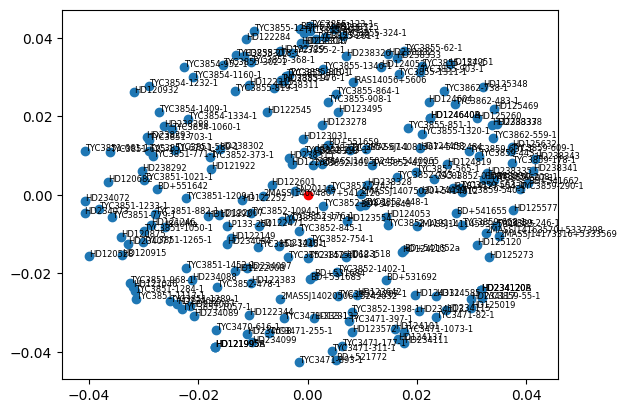

In [4]:
plt.scatter(df_ref.cluster_cx, df_ref.cluster_cy)
for i in range(len(df_ref)):
  r = df_ref.iloc[i]
  plt.annotate(r.id, (r.cluster_cx, r.cluster_cy), fontsize=6)
x, y = project(center.ra.degree, center.dec.degree, center.ra.degree, center.dec.degree, 0)
plt.scatter([x], [y], c='r')

plt.show()

In [5]:
df_ref.head()

,id,cluster_cx,cluster_cy,ra,dec
0,*86UMa,-0.026176,-0.008081,208.462558,53.728676
1,HD125632,0.037486,0.012252,214.732985,54.863782
2,HD125019,0.029951,-0.028765,213.820816,52.535924
3,HD125469,0.034161,0.021895,214.449591,55.425361
4,HD125260,0.031072,0.019533,214.127187,55.298356


## Read image and run star matching

In [87]:
# fname = r"D:\Astro\20230528-M101-Supernova\20230601\M101\Light\Light_02780_180.0sec_300gain_0.0C.fit"
# fname = r"D:\Astro\20230319-M81M82_M101_M13\Light-M101-300sec\Light_ASIImg_300sec_Bin1_-9.4C_gain200_2023-03-20_023749_frame0026.fit"
# fname = r"D:\Astro\20230528-M101-Supernova\M101\Light\Light_02650_180.0sec_300gain_-0.3C.fit"
fname = r"D:\Astro\20230528-M101-Supernova\M101\Light\Light_02693_180.0sec_300gain_0.0C.fit"

with fits.open(fname) as f:
    ph = f[0]
    img = ph.data
    img = np.expand_dims(img, axis=2)
    img16 = debayer_superpixel(img)

assert(img16.dtype == np.uint16)
assert(len(img16.shape) == 3)
assert(img16.shape[2] == 3)
img16 = cv2.cvtColor(img16, cv2.COLOR_RGB2GRAY)
img8 = ((img16 / np.iinfo(np.uint16).max) *np.iinfo(np.uint8).max).astype(np.uint8)
numStars = 20
star_img, df_tgt = StarFinder().find_stars(img8=np.squeeze(img8), img16=np.squeeze(img16), topk=numStars)

# votes, vVotingPairs = StarMatcher().matchStars(df_ref, df_tgt, return_merged=False)


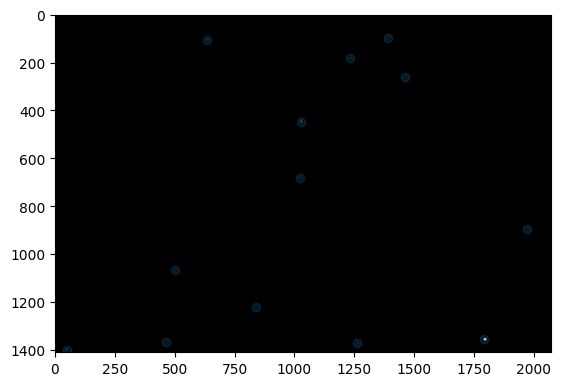

In [88]:
plt.imshow(star_img, cmap='gray')
plt.scatter(df_tgt.cluster_cx, df_tgt.cluster_cy, alpha=0.2)

In [89]:
m = StarMatcher()
tri_ref = m._getVertexSortedTriangles(df_ref, fov_deg=1)
tri_tgt = m._getVertexSortedTriangles(df_tgt, fov_deg=None)
print(f"Ref triangles: {len(tri_ref)}, Tgt triangles: {len(tri_tgt)}")

Ref triangles: 6397, Tgt triangles: 286


In [90]:

from itertools import product

vertex_sorted = True
down_votes = True
absolute_similar = True
vote_with_conf = True

votes_per_tol = {}

for TRIANGLETOLERANCE in [1e-3]: #, 2e-4, 1e-4, 1e-5, 1e-6]:
    votes = np.zeros((len(df_ref)+1, len(df_tgt)+1), dtype=np.float32)

    for tgt in tri_tgt.itertuples():
        if absolute_similar:
            similar_triangles = tri_ref[
                (tri_ref.fX >= tgt.fX - TRIANGLETOLERANCE/2) &
                (tri_ref.fX <= tgt.fX + TRIANGLETOLERANCE/2) &
                (tri_ref.fY >= tgt.fY - TRIANGLETOLERANCE/2) &
                (tri_ref.fY <= tgt.fY + TRIANGLETOLERANCE/2)
            ]
        else:
            ref_matches = tri_ref[
                (tri_ref.fX >= tgt.fX - TRIANGLETOLERANCE/2) &
                (tri_ref.fX <= tgt.fX + TRIANGLETOLERANCE/2)]
            similar_triangles = ref_matches[(ref_matches.fX-tgt.fX)**2 + (ref_matches.fY-tgt.fY)**2 < TRIANGLETOLERANCE**2]

        for ref in similar_triangles.itertuples():
            if vote_with_conf:
                err = ((ref.fX-tgt.fX)**2 + (ref.fY-tgt.fY)**2)
                upvote = 1/(np.exp(err*100))
                downvote = upvote / 4
            else:
                upvote = 1
                downvote = 1/4

            if vertex_sorted:
                # expect matched ABC vertices
                votes[ref.A, tgt.A] += upvote
                votes[ref.B, tgt.B] += upvote
                votes[ref.C, tgt.C] += upvote

                if down_votes:
                    votes[ref.A, tgt.B] -= downvote
                    votes[ref.A, tgt.C] -= downvote

                    votes[ref.B, tgt.A] -= downvote
                    votes[ref.B, tgt.C] -= downvote
                    
                    votes[ref.C, tgt.A] -= downvote
                    votes[ref.C, tgt.B] -= downvote
            else:
                # expect unordered star indices s1, s2, s3
                for a,b in product([ref.s1, ref.s2, ref.s3], [tgt.s1, tgt.s2, tgt.s3]):
                    votes[int(a), b] += upvote

    votes_per_tol[TRIANGLETOLERANCE] = votes
    print(f"TRIANGLETOLERANCE: {TRIANGLETOLERANCE}")
    print(f"Total triangle comparisons: {len(tri_ref) * len(tri_tgt)}")
    print(f"Total votes: {np.sum(votes)}, hit-ratio: {np.sum(votes) / (len(tri_ref) * len(tri_tgt))}")

TRIANGLETOLERANCE: 0.001
Total triangle comparisons: 1829542
Total votes: 28.499374389648438, hit-ratio: 1.5577327216127553e-05


In [91]:
votes=votes_per_tol[1e-3]

In [92]:
with open('votes.csv', 'wt') as f:  
  arr = votes.flatten()
  for i in range(arr.shape[0]):
    f.write(f"{arr[i]}\n")


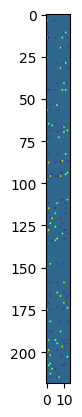

In [93]:
plt.imshow(votes)

(array([1.000e+00, 1.110e+02, 0.000e+00, 2.897e+03, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 5.600e+01]),
 array([-0.49999076, -0.34999204, -0.19999334, -0.04999463,  0.10000409,
         0.2500028 ,  0.40000153,  0.55000025,  0.69999892,  0.84999764,
         0.99999636]),
 <BarContainer object of 10 artists>)

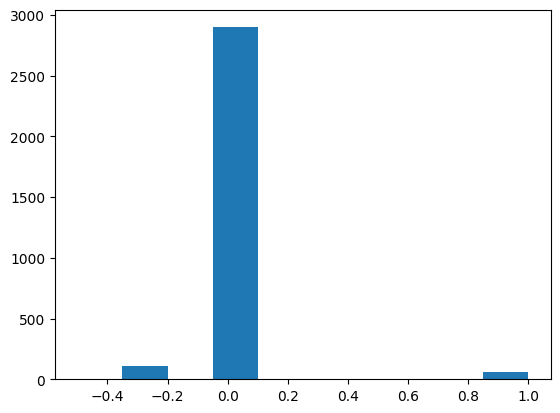

In [94]:
plt.hist(votes.flatten())

In [95]:
# Produce sorted list of star pairs with highest votes
vVotingPairs = np.column_stack(np.unravel_index(np.argsort(votes, axis=None), shape=votes.shape))[::-1]

In [96]:
cutoff = votes.max() / 4
# print(f"Vote cutoff threshold: {cutoff}")
topVotePairs = list(filter(lambda r: votes[r[0],r[1]] > cutoff, vVotingPairs))

matches = []
for vp in topVotePairs:
    s1, s2 = vp
    # if s1 == 0 or s2 == 0: # WHY ?
    #     continue
    if np.argmax(votes[:, s2]) == s1 and np.argmax(votes[s1, :]) == s2:
        matches.append((s1, s2))

df_tgt['starno'] = None
df_tgt['votes'] = None
for m1, m2 in matches:
    df_tgt.loc[m2, 'starno'] = m1
    df_tgt.loc[m2, 'votes'] = votes[m1, m2]

In [97]:
d = []
# n = []
for i in range(len(df_tgt)):
    m = votes[:,i]
    ave = (m.sum() - m.max())/(len(m)-1)
    d.append((m.max()-ave)/ave)
    # n.append(len(np.argwhere(m > 2 * ave)))
print(d)
# print(n)
# plt.plot(m)
# plt.plot(np.arange(0, len(m)), np.full(len(m), ave))


[217.0034044657416, 86.2002037479747, 86.20192001499977, 435.00992759706514, nan, 217.0060813340882, 144.33791020364043, -146294167.88, 144.3375694697442, 144.3359061720153, 144.33800261029995, 144.33406100661472, 144.33733845389412]


C:\Users\anand\AppData\Local\Temp\ipykernel_9256\408611718.py:6: RuntimeWarning: invalid value encountered in scalar divide
  d.append((m.max()-ave)/ave)


## Matched stars

In [98]:
# display(df_tgt[~df_tgt.starno.isnull()])
df_tgt

,area,cluster_cx,cluster_cy,iwc_cx,iwc_cy,gaussian_cx,gaussian_cy,box,tile_4,tile_32,fwhm_x,fwhm_y,starno,votes
0,249,1791.710843,1356.469880,16.000977,16.000977,18.585872,18.599083,"[1773, 1338, 1810, 1375]",176050,2786,26.423958,26.782142,4,0.99999
1,166,1026.180723,448.909639,12.000977,14.000977,15.288727,13.129045,"[1013, 433, 1040, 464]",58273,942,39.481831,34.662956,199,0.999978
2,148,48.364865,1399.952703,13.000977,10.000977,12.216249,14.017185,"[34, 1387, 63, 1411]",181312,2862,20.257322,24.243726,148,0.999996
3,125,1022.296000,682.888000,11.000977,10.000977,11.319119,12.146540,"[1010, 671, 1035, 694]",88834,1397,49.639251,54.320727,210,0.99999
4,119,1462.109244,258.563025,10.000977,11.000977,12.452034,10.835891,"[1451, 246, 1474, 271]",34036,566,54.321144,48.667521,None,None
5,118,637.186441,106.355932,10.000977,11.000977,12.620982,11.422424,"[626, 94, 649, 119]",14145,215,28.320563,25.582214,134,0.99999
6,87,1231.137931,182.459770,8.000977,9.000977,10.820460,9.352043,"[1222, 172, 1241, 193]",24136,428,23.165808,19.938404,165,0.999996
7,86,1262.093023,1372.511628,8.000977,9.000977,9.953158,8.983690,"[1253, 1362, 1272, 1383]",177990,2834,23.151521,20.821596,215,0.999978
8,84,1972.333333,895.833333,8.000977,8.000977,9.356495,9.935660,"[1962, 886, 1983, 905]",116525,1882,15.499846,16.945215,20,0.999993
9,77,465.454545,1366.363636,9.000977,7.000977,8.300074,10.518812,"[455, 1358, 476, 1375]",177272,2810,18.007504,21.795358,130,0.999993


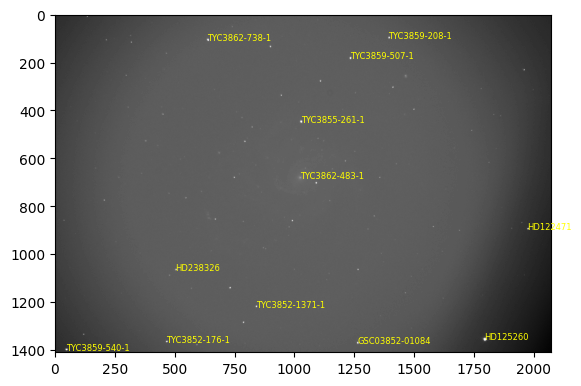

In [99]:
plt.imshow(img8, cmap='gray')
for idx, star in df_tgt[~df_tgt.starno.isnull()].iterrows():
    # print(star.starno, (star.cluster_cx, star.cluster_cy))
    plt.annotate(df_ref.loc[star.starno].id, (star.cluster_cx, star.cluster_cy), fontsize=6, color='yellow')

## Calculate transformation matrix
From known star mapping to image, compute affine transformation to map database projection to image

In [100]:
img_stars = df_tgt[~df_tgt.starno.isnull()][['starno','cluster_cx', 'cluster_cy', 'votes']]
img_ref_stars = df_ref[['id','cluster_cx', 'cluster_cy', 'ra', 'dec']].join(img_stars.set_index('starno'), rsuffix='r', how='right')
display(img_ref_stars)

,id,cluster_cx,cluster_cy,ra,dec,cluster_cxr,cluster_cyr,votes
starno,,,,,,,,
4,HD125260,0.031072,0.019533,214.127187,55.298356,1791.710843,1356.469880,0.99999
199,TYC3855-261-1,0.001595,0.039726,211.163993,56.495216,1026.180723,448.909639,0.999978
148,TYC3859-540-1,0.028191,0.000638,213.762342,54.223562,48.364865,1399.952703,0.999996
210,TYC3862-483-1,0.026969,0.023287,213.729165,55.523099,1022.296000,682.888000,0.99999
134,TYC3862-738-1,0.024955,0.026472,213.537167,55.709812,637.186441,106.355932,0.99999
165,TYC3859-507-1,0.033433,0.003641,214.289530,54.382568,1231.137931,182.459770,0.999996
215,GSC03852-01084,0.023143,0.004081,213.278650,54.431009,1262.093023,1372.511628,0.999978
20,HD122471,-0.008933,-0.007802,210.132458,53.768432,1972.333333,895.833333,0.999993
130,TYC3852-176-1,-0.003258,-0.006004,210.681806,53.874197,465.454545,1366.363636,0.999993


In [101]:
matched_star_triple = img_ref_stars.sort_values('votes', ascending=False)[:3]
display(matched_star_triple)

,id,cluster_cx,cluster_cy,ra,dec,cluster_cxr,cluster_cyr,votes
starno,,,,,,,,
148,TYC3859-540-1,0.028191,0.000638,213.762342,54.223562,48.364865,1399.952703,0.999996
165,TYC3859-507-1,0.033433,0.003641,214.289530,54.382568,1231.137931,182.459770,0.999996
159,TYC3859-208-1,0.034071,0.003773,214.352861,54.388426,1392.600000,97.000000,0.999996


In [102]:
src = np.array([(row.cluster_cx, row.cluster_cy) for _, row in matched_star_triple.iterrows()], dtype=np.float32)
dst = np.array([(row.cluster_cxr, row.cluster_cyr) for _, row in matched_star_triple.iterrows()], dtype=np.float32)

In [103]:
import cv2
tx = cv2.getAffineTransform(src, dst)
print(tx)

[[ 268820.63592009  -75422.71725109   -7481.71308498]
 [ -78156.63098696 -269020.715348      3774.9880347 ]]


In [104]:
pts = np.array([[(r.cluster_cx, r.cluster_cy) for _,r in df_ref.iterrows()]], dtype=np.float32)
tx_pts = cv2.transform(pts, tx)
print(pts.shape, tx_pts.shape)
display(np.hstack([pts[0], tx_pts[0]])[0:5])

(1, 218, 2) (1, 218, 2)


array([[-2.6176000e-02, -8.0805570e-03, -1.3908904e+04,  7.9946533e+03],
       [ 3.7485849e-02,  1.2251842e-02,  1.6711895e+03, -2.4507791e+03],
       [ 2.9950602e-02, -2.8765356e-02,  2.7391875e+03,  9.1726270e+03],
       [ 3.4160659e-02,  2.1895375e-02,  4.9968262e+01, -4.7852031e+03],
       [ 3.1072250e-02,  1.9532695e-02, -6.0206055e+02, -3.9082141e+03]],
      dtype=float32)

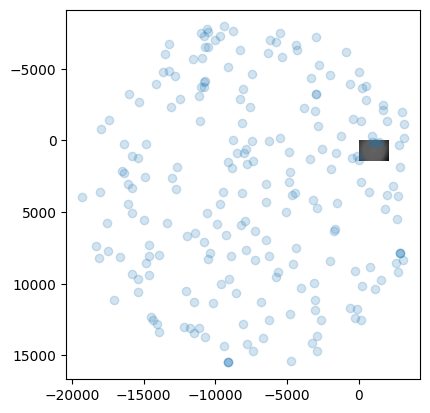

In [105]:
# pts = tx * pts
plt.imshow(img8, cmap='gray')
plt.scatter(tx_pts[0, :, 0], tx_pts[0, :, 1], alpha=0.2)

## Map pixel coordinated to RA,DEC
Use linear regression to fit a function to map pixel coordinates to RA,DEC.
Useful to find RA, DEC of image center.

In [106]:
from sklearn.linear_model import LinearRegression
X = img_ref_stars[['cluster_cxr', 'cluster_cyr']]
y = img_ref_stars[['ra', 'dec']]
reg = LinearRegression().fit(X, y)
pred_center = reg.predict([[img8.shape[1]//2, img8.shape[0]//2]])[0]
pred_center = SkyCoord(pred_center[0] * u.degree, pred_center[1] * u.degree, frame=ICRS)
print(f"Image Center RA,DEC: {pred_center}")
print(f"Separation from target: {center.separation(pred_center).arcminute}")

Image Center RA,DEC: <SkyCoord (ICRS): (ra, dec) in deg
    (212.75505806, 54.93265453)>
Separation from target: 74.61289661967398


c:\Users\anand\anaconda3\envs\astro\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
